In [1]:
import sys 
import os 
# Add the project root to sys.path
sys.path.append(os.path.abspath('../'))

from Util.Client import download_file, example_key, example_file_name

print(example_key)
print(example_file_name)

ds000228/sub-pixar001/anat/sub-pixar001_T1w.nii.gz
sub-pixar001_T1w.nii.gz


In [2]:
download_file(
    key = example_key,
    the_file_name_you_want = example_file_name
)

'Downloaded to ../Data/sub-pixar001_T1w.nii.gz'

In [3]:
import nibabel as nib

nifti = nib.load('..\Data\sub-pixar001_T1w.nii.gz')

print(nifti)


<class 'nibabel.nifti1.Nifti1Image'>
data shape (176, 192, 192)
affine:
[[   1.            0.            0.          -84.5       ]
 [   0.            0.97629595   -0.21643978  -60.18632507]
 [   0.            0.21643978    0.97629595 -131.30987549]
 [   0.            0.            0.            1.        ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 54
dim             : [  3 176 192 192   1   0   0   0]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.   1.   1.   1.   2.53 0.   0.   0.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0

In [4]:
nifti.header['sform_code']

array(1, dtype=int16)

In [5]:
nifti.shape

(176, 192, 192)

In [6]:
# An array of images
# each image is from the mri scan
# each image is a `slice` of the brain
mri_scan = nifti.get_fdata()

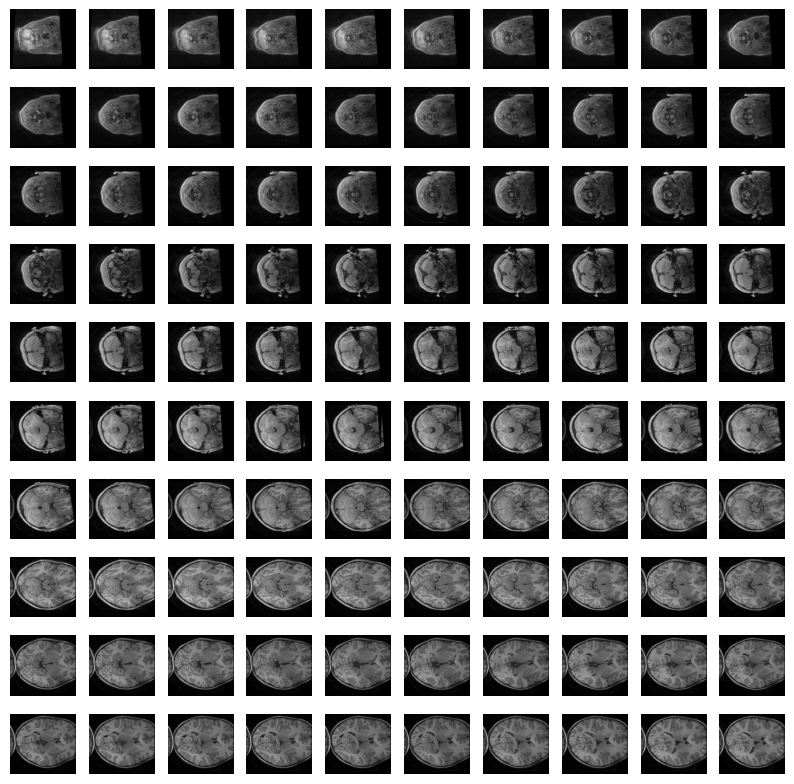

In [ ]:
import matplotlib.pyplot as plt

n = 10

fig, axis = plt.subplots(
    nrows = n,
    ncols = n,
    figsize = (10, 10)
)


xMax, yMax, zMax = mri_scan.shape
step = zMax // (n**2)

current_slice = 0 # index of current slice from the MRI scan
# for each axis ...
for i in range(n):
    for j in range(n):

        axis[i][j].imshow(
            mri_scan[:, :, current_slice],
            cmap = 'gray',
        )

        axis[i][j].axis('off')

        current_slice += step